In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.densenet import preprocess_input

# Load and prepare the dataset

In [2]:
batch_size = 16
img_height = 224
img_width = 224

In [3]:
data_dir = "D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE"
data_dir = pathlib.Path(data_dir)
list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'), shuffle=False)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)
image_count = len(list_ds)
print(image_count)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

30007
24006
6001


In [4]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [5]:
def data_augmentation(batch, blur_range=(0.0, 0.2*255.0), noise_range=(0.0, 0.2*255.0)):
    # Apply random Gaussian blur and noise to each image in the batch
    def augment_image(image):
        # Apply Gaussian blur with random severity within `blur_range`
        blur_sigma = np.random.uniform(*blur_range)
        image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3), sigma=blur_sigma)

        # Add Gaussian noise with random severity within `noise_range`
        noise_scale = np.random.uniform(*noise_range)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_scale)
        image = tf.add(image, noise)

        return image

    augmented_batch = tf.map_fn(augment_image, batch)
    return augmented_batch

In [6]:
train_ds = train_ds.batch(batch_size)

# Extract one batch and apply data augmentation and data preprocessing to it

In [7]:
batch_ = next(iter(train_ds))[0]
augmented_batch_ = data_augmentation(batch_)
preprocessed_augmented_batch = preprocess_input(augmented_batch_)

In [8]:
def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        plt.subplot(4, 4, n + 1)
        # if the image is a tensor, convert it to a numpy array
        if isinstance(image_batch[n], tf.Tensor):
            plt.imshow(image_batch[n].numpy().astype("uint8"))
        else:
            plt.imshow(image_batch[n].astype("uint8"))
        plt.axis("off")

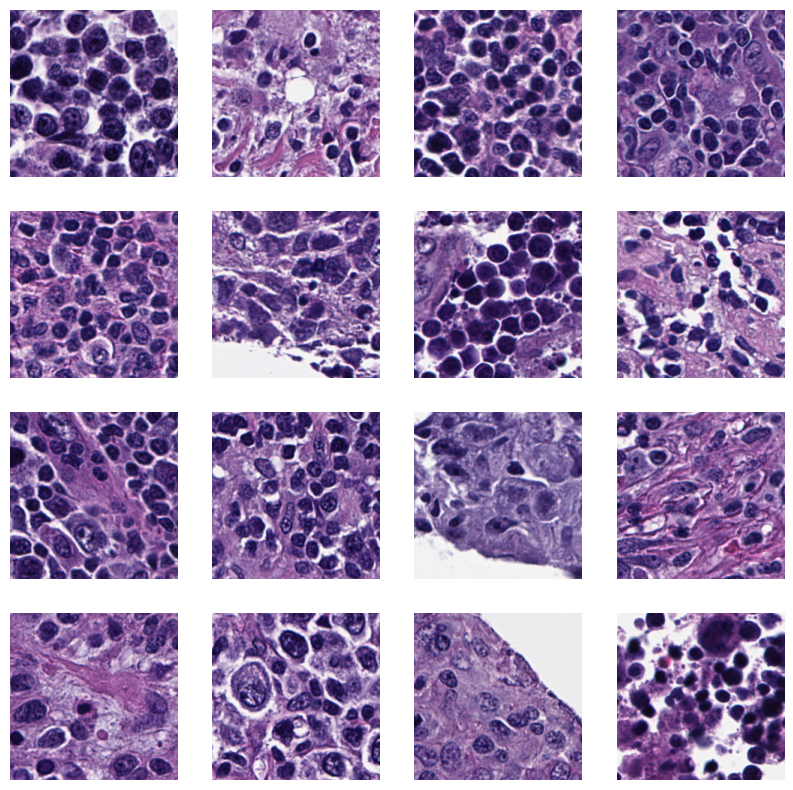

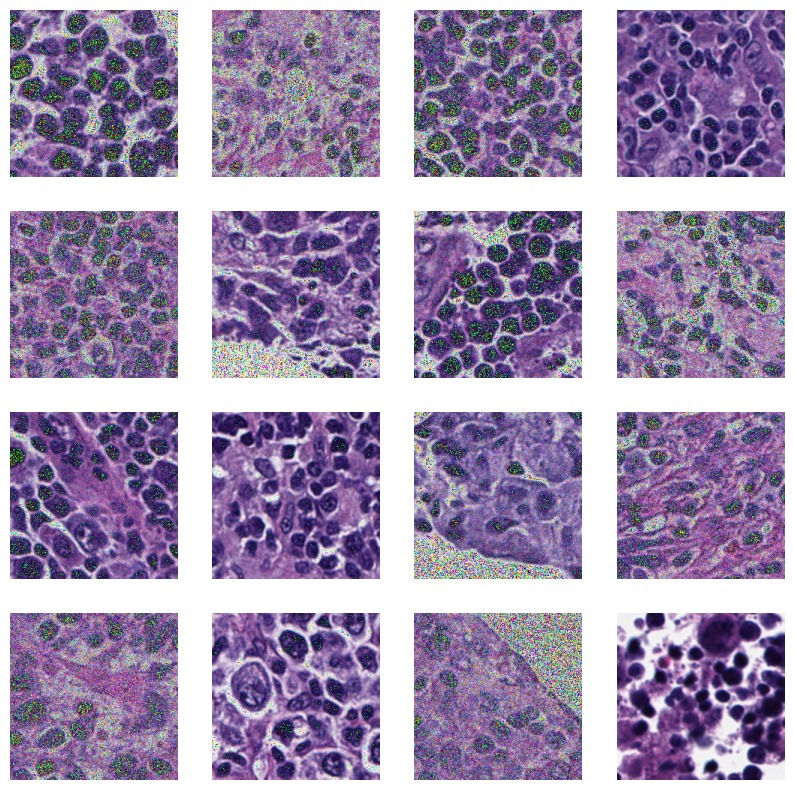

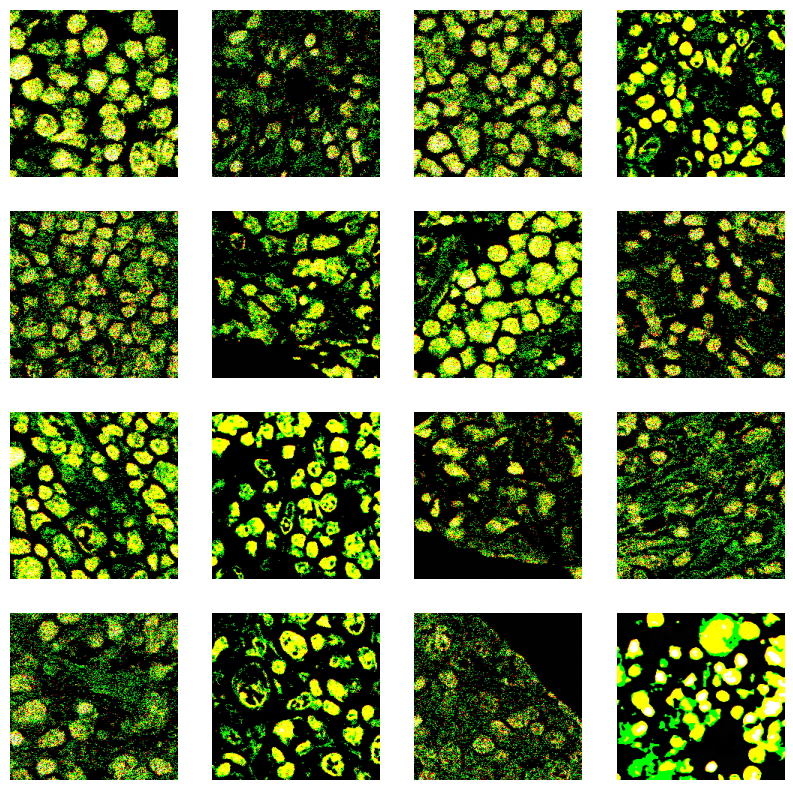

In [9]:
show_batch(batch_)
show_batch(augmented_batch_)
show_batch(preprocessed_augmented_batch)

# Load the model and show the output for the corresponding batch

In [10]:
model = tf.keras.models.load_model("../Models/2.12")

In [11]:
output_batch = model.predict(preprocessed_augmented_batch)

1/1 [==============================] - 6s 6s/step


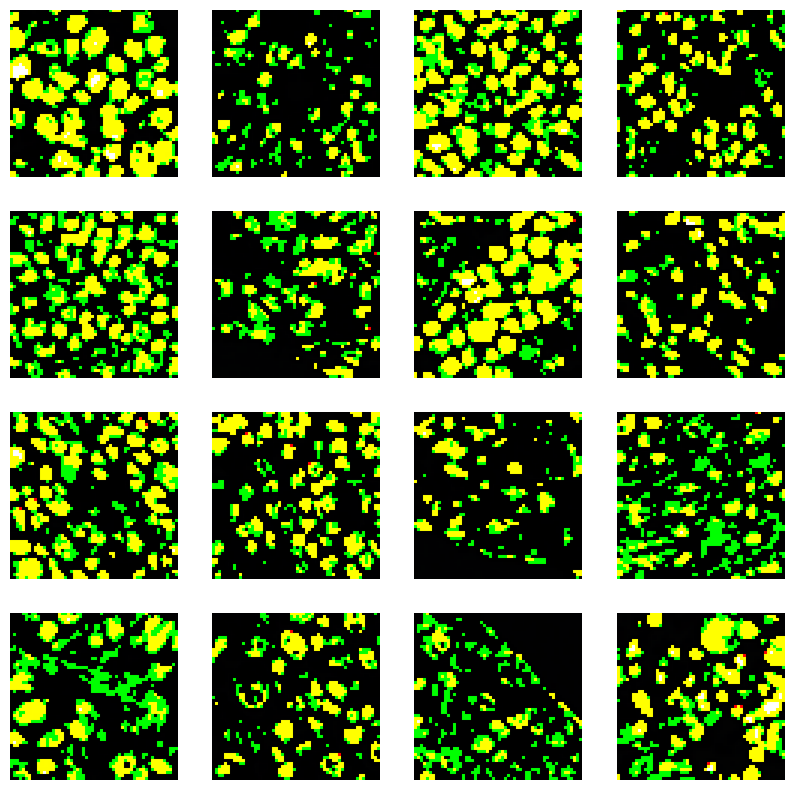

In [12]:
show_batch(output_batch)

In [13]:
# rescale the output to the range [0, 255]
output_batch = (output_batch - output_batch.min()) / (output_batch.max() - output_batch.min())
output_batch = output_batch * 255

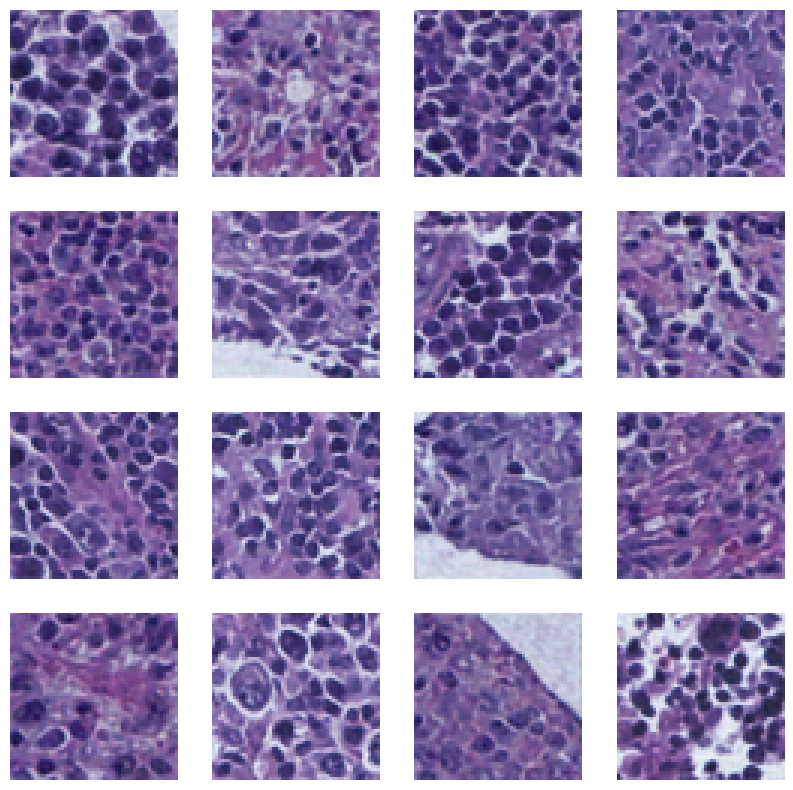

In [14]:
show_batch(output_batch)

# Show the extracted features from the output layer of the encoder part

In [15]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
ae_feature_extractor = Model(inputs=model.layers[-2].inputs, outputs=GlobalAveragePooling2D()(model.layers[-2].outputs[-1]))

In [16]:
batch_features = ae_feature_extractor.predict(preprocessed_augmented_batch)

1/1 [==============================] - 1s 1s/step


In [18]:
# Convert batch_features into a pandas dataframe
import pandas as pd
df = pd.DataFrame(batch_features)

In [21]:
df = df.rename(columns={i: f"feature_{i}" for i in range(512)})
df = df.rename(index={i: f"patch_{i}" for i in range(16)})

In [22]:
df

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
patch_0   -0.117807  -0.119272   0.001256  -0.016270  -0.217834   0.036796   
patch_1   -0.038501  -0.184839   0.001446   0.032570  -0.142373   0.113236   
patch_2   -0.050467  -0.113570   0.014906   0.032682  -0.197398   0.055823   
patch_3   -0.159834   0.013381  -0.097937  -0.033404  -0.111195  -0.042475   
patch_4   -0.041702  -0.107114   0.007807   0.056782  -0.183233   0.079653   
patch_5   -0.104845  -0.115130  -0.031730  -0.066867  -0.149266   0.067104   
patch_6   -0.168907  -0.145476  -0.055138   0.003242  -0.244050   0.018905   
patch_7   -0.048751  -0.133848   0.021267   0.003371  -0.122895   0.061519   
patch_8   -0.160851  -0.046651  -0.066520  -0.014377  -0.165220   0.073816   
patch_9   -0.113262  -0.009726  -0.095776  -0.057448  -0.140801  -0.082587   
patch_10  -0.061439  -0.183162  -0.050171  -0.030444  -0.143904   0.054306   
patch_11  -0.077045  -0.100566  -0.037240  -0.020622  -0.118923   0.116607   
patch_12  -0.005963  -0.189202  -0.004084   0.086031  -0.133131   0.116523   
patch_13  -0.148198  -0.011850  -0.058500  -0.064098  -0.184596  -0.044972   
patch_14  -0.035737  -0.194912  -0.021662   0.059817  -0.156002   0.101587   
patch_15  -0.103625  -0.085728  -0.098991  -0.082714  -0.168286  -0.068521   

          feature_6  feature_7  feature_8  feature_9  ...  feature_502  \
patch_0   -0.000917  -0.157875  -0.145549  -0.115466  ...    -0.177399   
patch_1   -0.019186  -0.049160  -0.177620  -0.238932  ...    -0.250761   
patch_2    0.019173  -0.155638  -0.162829  -0.157318  ...    -0.155220   
patch_3    0.009019  -0.065752  -0.158993  -0.053142  ...    -0.157720   
patch_4   -0.039358  -0.136281  -0.187131  -0.171175  ...    -0.229059   
patch_5   -0.059412  -0.047136  -0.087905  -0.079968  ...    -0.111979   
patch_6    0.004829  -0.175741  -0.151904  -0.123928  ...    -0.180945   
patch_7   -0.013636  -0.067297  -0.134284  -0.150727  ...    -0.178890   
patch_8    0.034093  -0.097958  -0.121470  -0.090780  ...    -0.139520   
patch_9    0.065497  -0.076279  -0.140870  -0.049672  ...    -0.068970   
patch_10  -0.037549  -0.066259  -0.122007  -0.145961  ...    -0.191008   
patch_11  -0.027231  -0.081749  -0.153349  -0.119646  ...    -0.216199   
patch_12  -0.038858  -0.095780  -0.186730  -0.214318  ...    -0.291234   
patch_13   0.039026  -0.056044  -0.134459  -0.072576  ...    -0.087674   
patch_14  -0.041832  -0.080347  -0.142119  -0.202270  ...    -0.275478   
patch_15   0.056688  -0.068929  -0.215968  -0.097065  ...    -0.111895   

          feature_503  feature_504  feature_505  feature_506  feature_507  \
patch_0     -0.004948    -0.120316    -0.022402    -0.054443    -0.196799   
patch_1      0.078492    -0.072215    -0.123536    -0.150022    -0.203585   
patch_2     -0.000988    -0.109908    -0.048849    -0.106447    -0.218145   
patch_3      0.067662    -0.035564    -0.021111    -0.127667     0.000927   
patch_4     -0.006295    -0.130459    -0.087637    -0.156197    -0.230283   
patch_5      0.040563    -0.100451    -0.054968    -0.124346    -0.094961   
patch_6     -0.011995    -0.130361    -0.006702    -0.081969    -0.144463   
patch_7      0.031814    -0.072630    -0.090282    -0.096713    -0.171828   
patch_8      0.047943    -0.076375     0.000557    -0.082612    -0.103580   
patch_9      0.047049     0.009547    -0.027718    -0.096851    -0.006277   
patch_10     0.062604    -0.136085    -0.072940    -0.160873    -0.182930   
patch_11     0.022850    -0.115467    -0.089545    -0.154691    -0.151397   
patch_12     0.051683    -0.104827    -0.118465    -0.190926    -0.205881   
patch_13     0.081905    -0.016374    -0.020266    -0.058025     0.011378   
patch_14     0.057016    -0.141953    -0.121138    -0.193682    -0.217913   
patch_15     0.020080     0.028700     0.005766    -0.165180    -0.053617   

          feature_508  feature_509  feature_510  feature_511  
patch_0     -0.039913    -0.025595    -0.045889    